In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import hdf5storage
import h5py
import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
import matplotlib
from matplotlib.ticker import AutoMinorLocator


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\project_log'

In [11]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

In [3]:
df_ = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')

df = pd.DataFrame()

for basepath in df_.basepath:
    cell_metrics,data = loading.load_cell_metrics(basepath)

    df = df.append(cell_metrics,ignore_index=True)



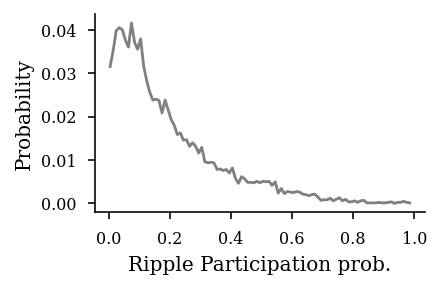

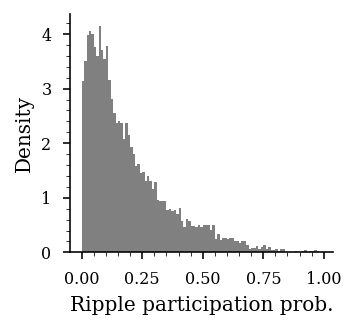

In [9]:
# fig, axs = plt.subplots(2,4, figsize=functions.set_size('thesis', fraction=1, subplots=(2, 4)), edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.4)
# axs = axs.ravel()
idx = (df.putativeCellType == "Pyramidal Cell") & ((df.brainRegion == "CA1") | (df.brainRegion == "lCA1") | (df.brainRegion == "rCA1"))

plt.figure(figsize=functions.set_size('thesis', fraction=.5, subplots=(1, 1)), edgecolor='k')
bin_width = 0.01
bin_edges = np.arange(0,1,bin_width)
values,values_ = np.histogram(df[idx].ripple_particip,bins=bin_edges)
plt.plot(bin_edges[:-1]+bin_width/2,values / values.sum(),color="grey")
# plt.xscale("log")
plt.xlabel('Ripple Participation prob.')
plt.ylabel('Probability')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5, 1)), edgecolor='k')
plt.hist(df[idx].ripple_particip,bins=np.arange(0,1,bin_width),density=True,color="grey")
plt.xlabel('Ripple participation prob.')
plt.ylabel('Density')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'all_data_ca1_pyr_participation.svg'),dpi=300,bbox_inches='tight')


In [21]:
# df[idx & (df.ripple_particip > .5)]

basepath = r'A:\\Data\\AYA9\\day20'

cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")))

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
                                                data['epochs'].stopTime]).T])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [49]:
filename = glob.glob(os.path.join(basepath,'*.lfp'))[0]
nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)

rip_ch = ripples.ripple_channel.unique()[0]
for sh in shank_to_channel:
    if np.any(shank_to_channel[sh] == rip_ch):
        shank = sh
        break

channel_idx = np.where(shank_to_channel[shank] == rip_ch)[0][0]

lfp,ts = loading.loadLFP(filename, n_channels=nChannels, channel=shank_to_channel[shank], frequency=fs, precision='int16')
# shank_to_channel


In [55]:
lfp_obj = nel.AnalogSignalArray(data=lfp.T,fs=fs)
lfp_obj_zscore = lfp_obj.zscore()
lfp_obj

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


<AnalogSignalArray at 0x1a7b4f8abe0: 32 signals> for a total of 4:23:26:100 hours

In [85]:
lfp_obj.data.shape

(32, 19757625)

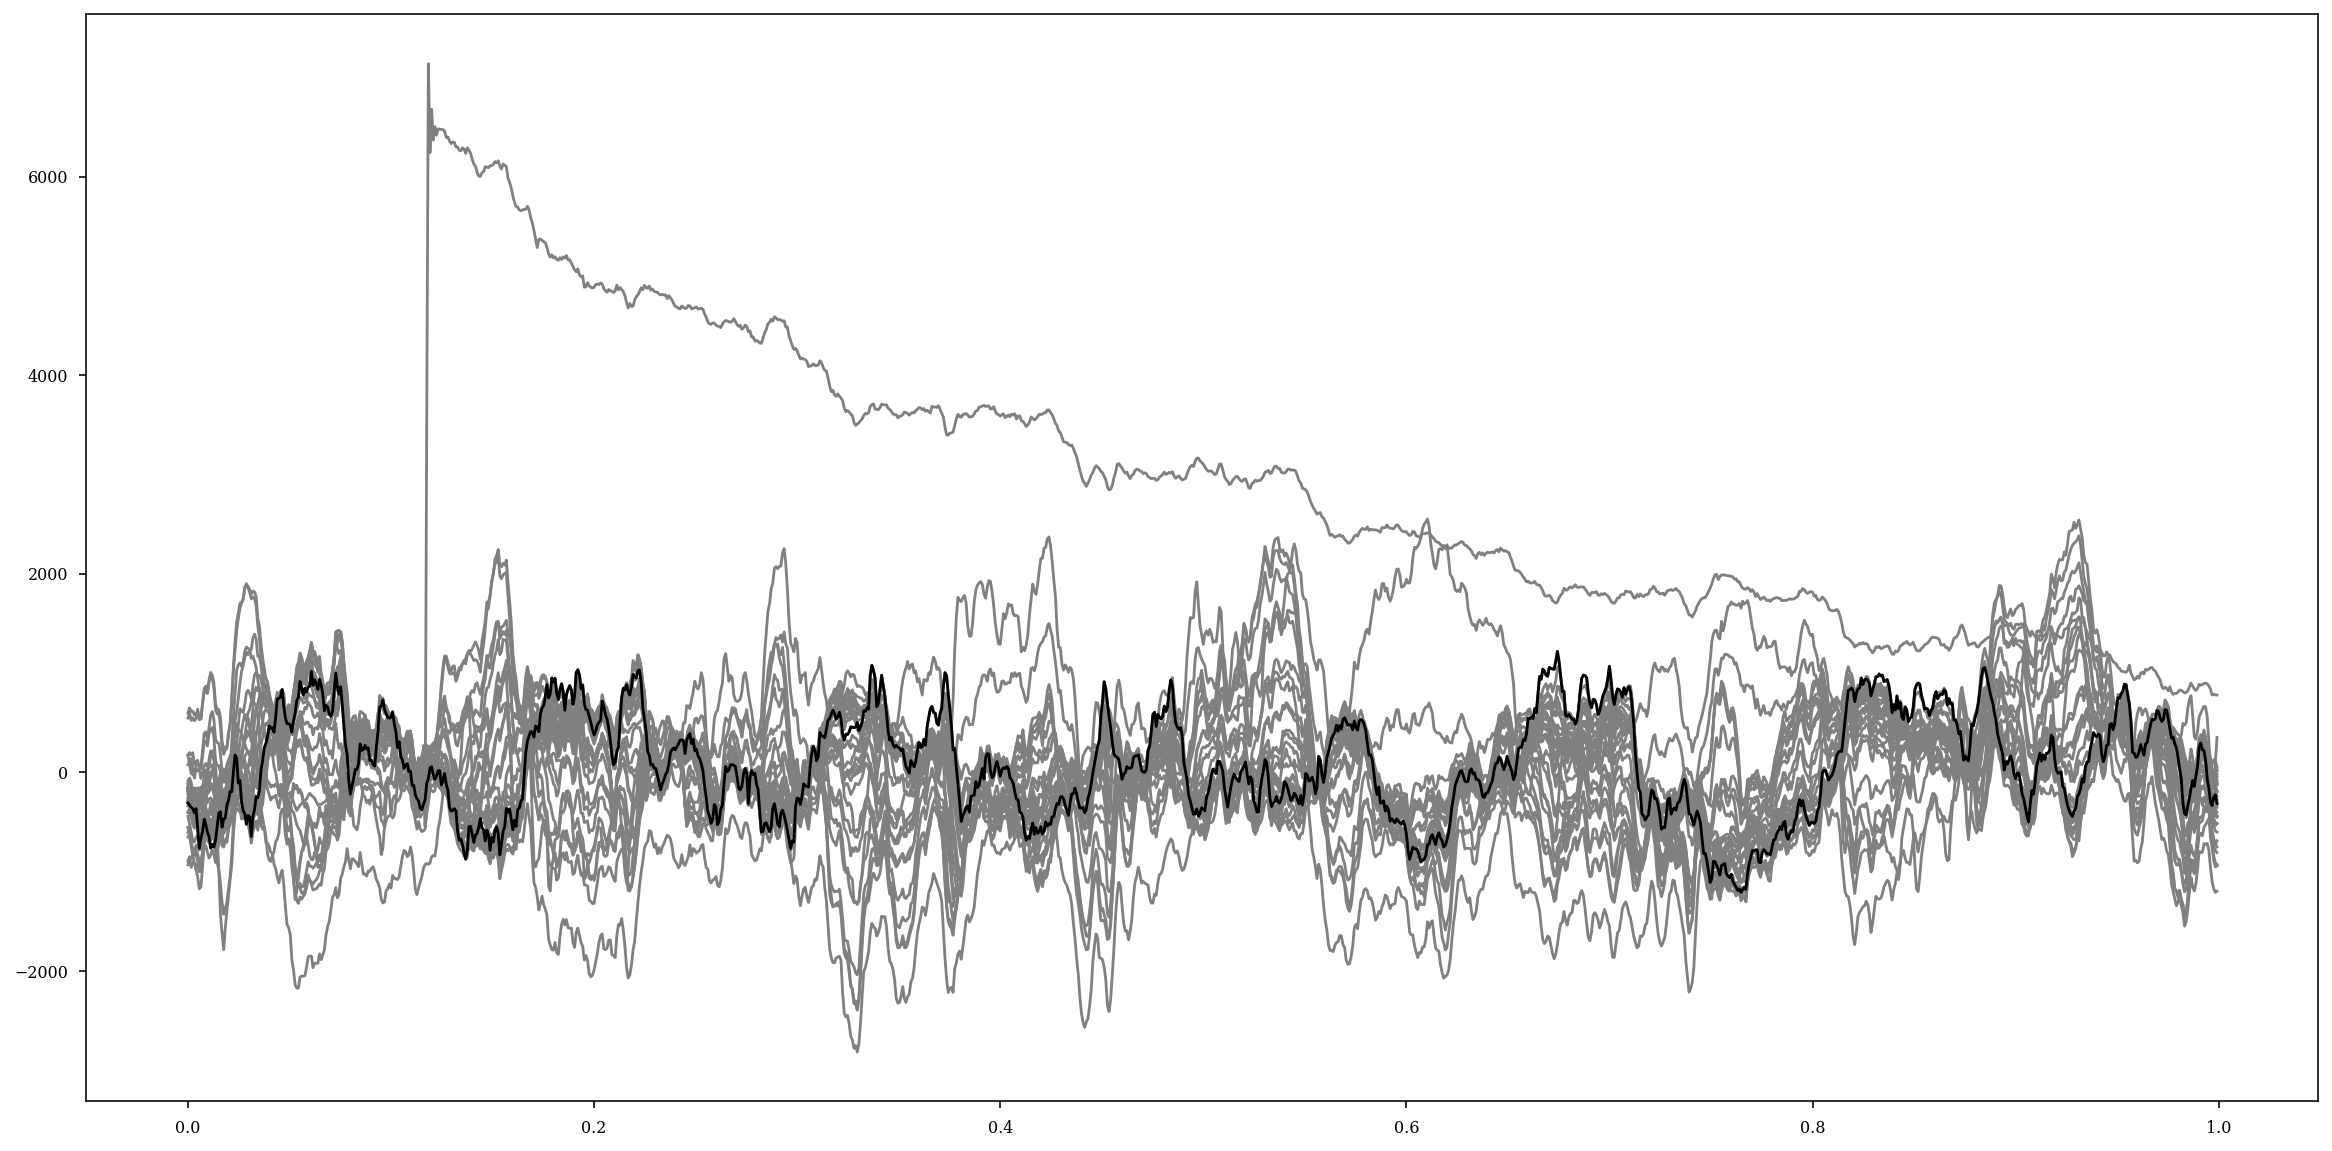

In [107]:
plt.figure(figsize=(20,10))
plt.plot(ts[0:1250],lfp_obj.data[:,0:1250].T,color='grey')
plt.plot(ts[0:1250],lfp_obj.data[channel_idx,0:1250],color='k')


plt.show()
# +np.arange(0,lfp_obj.data.shape[0])*100

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


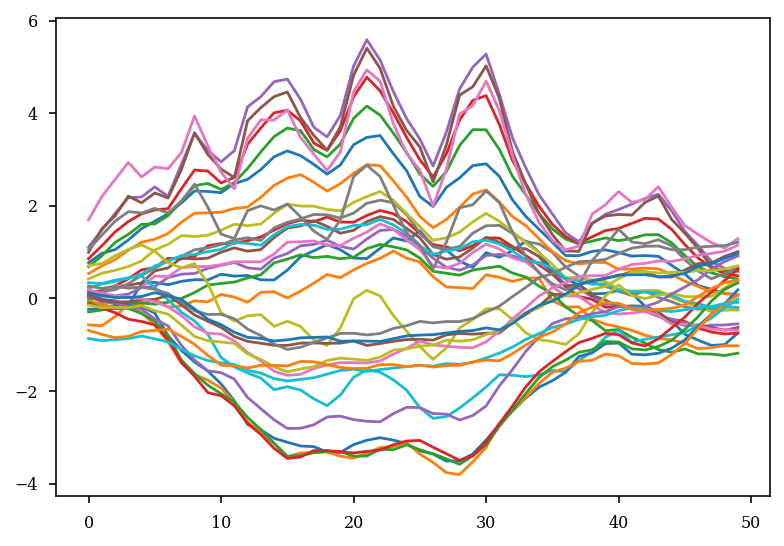

In [140]:
plt.plot(lfp_obj[ripple_epochs[2000]].data.T)
plt.show()

In [141]:
# cell_metrics[(cell_metrics.ripple_particip > 0.5)]

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


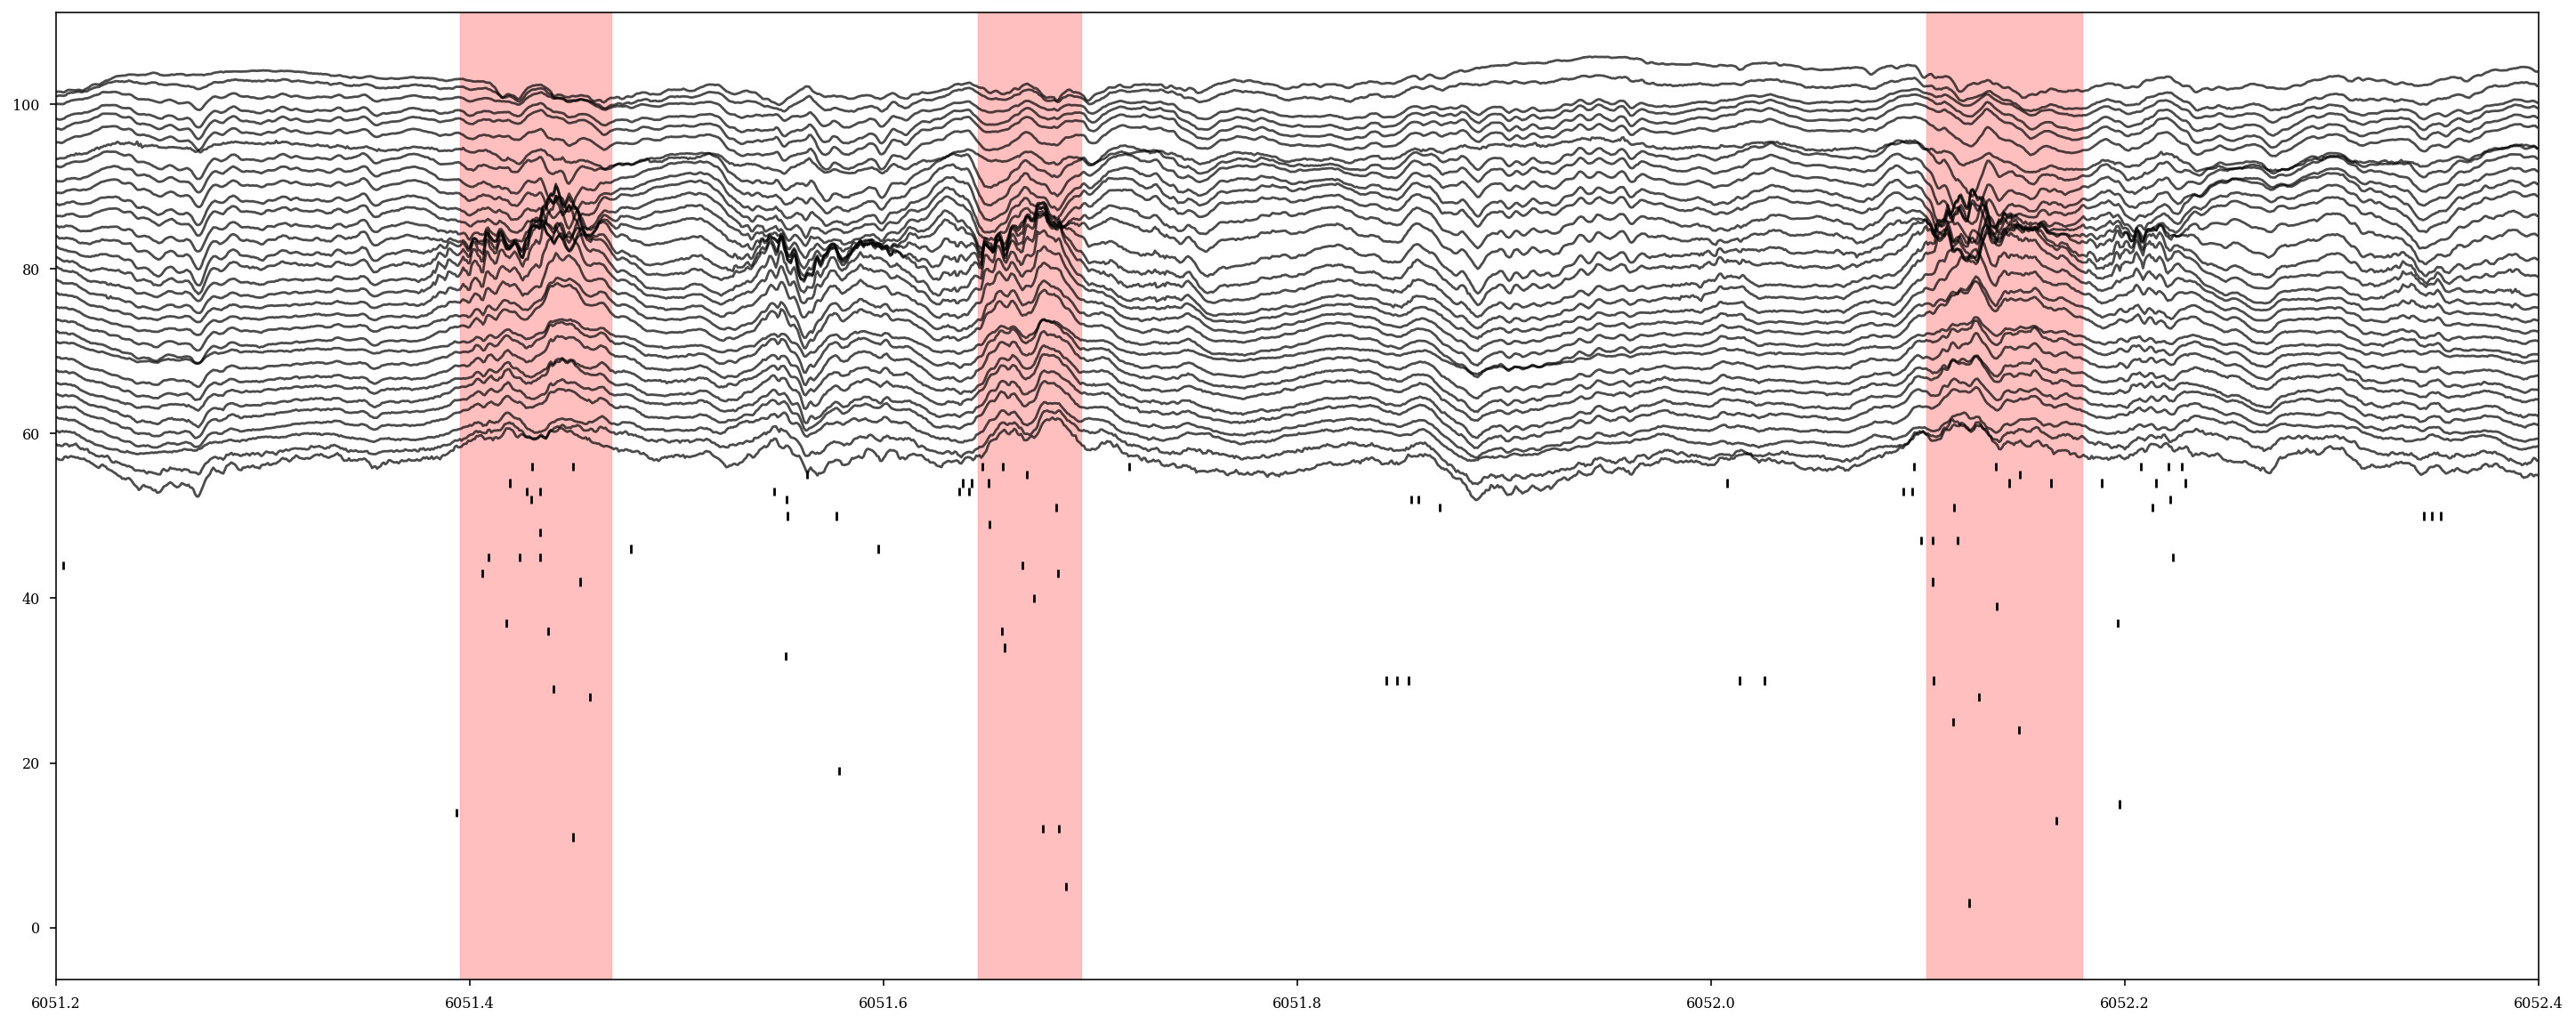

In [126]:
plotting_epoch = nel.EpochArray([np.array([6051.2,6052.4]).T])

idx = np.argsort(cell_metrics.ripple_particip)
plt.figure(figsize=(25,10))
plt.plot(lfp_obj[plotting_epoch]._abscissa_vals,lfp_obj[plotting_epoch].data.T+(np.arange(0,lfp_obj.data.shape[0])*1.5)+st_unit.n_active,color='k',alpha=.7)

plt.eventplot(st_unit[plotting_epoch].data[idx],color='k')

for rip in ripple_epochs[plotting_epoch]:
    plt.axvspan(rip.start,rip.stop,color='r',alpha=.25,zorder=-1000)
plt.xlim(plotting_epoch.start,plotting_epoch.stop)    
plt.show()

In [129]:
ripple_epochs.starts
ripple_epochs[2].starts

array([206.6392])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


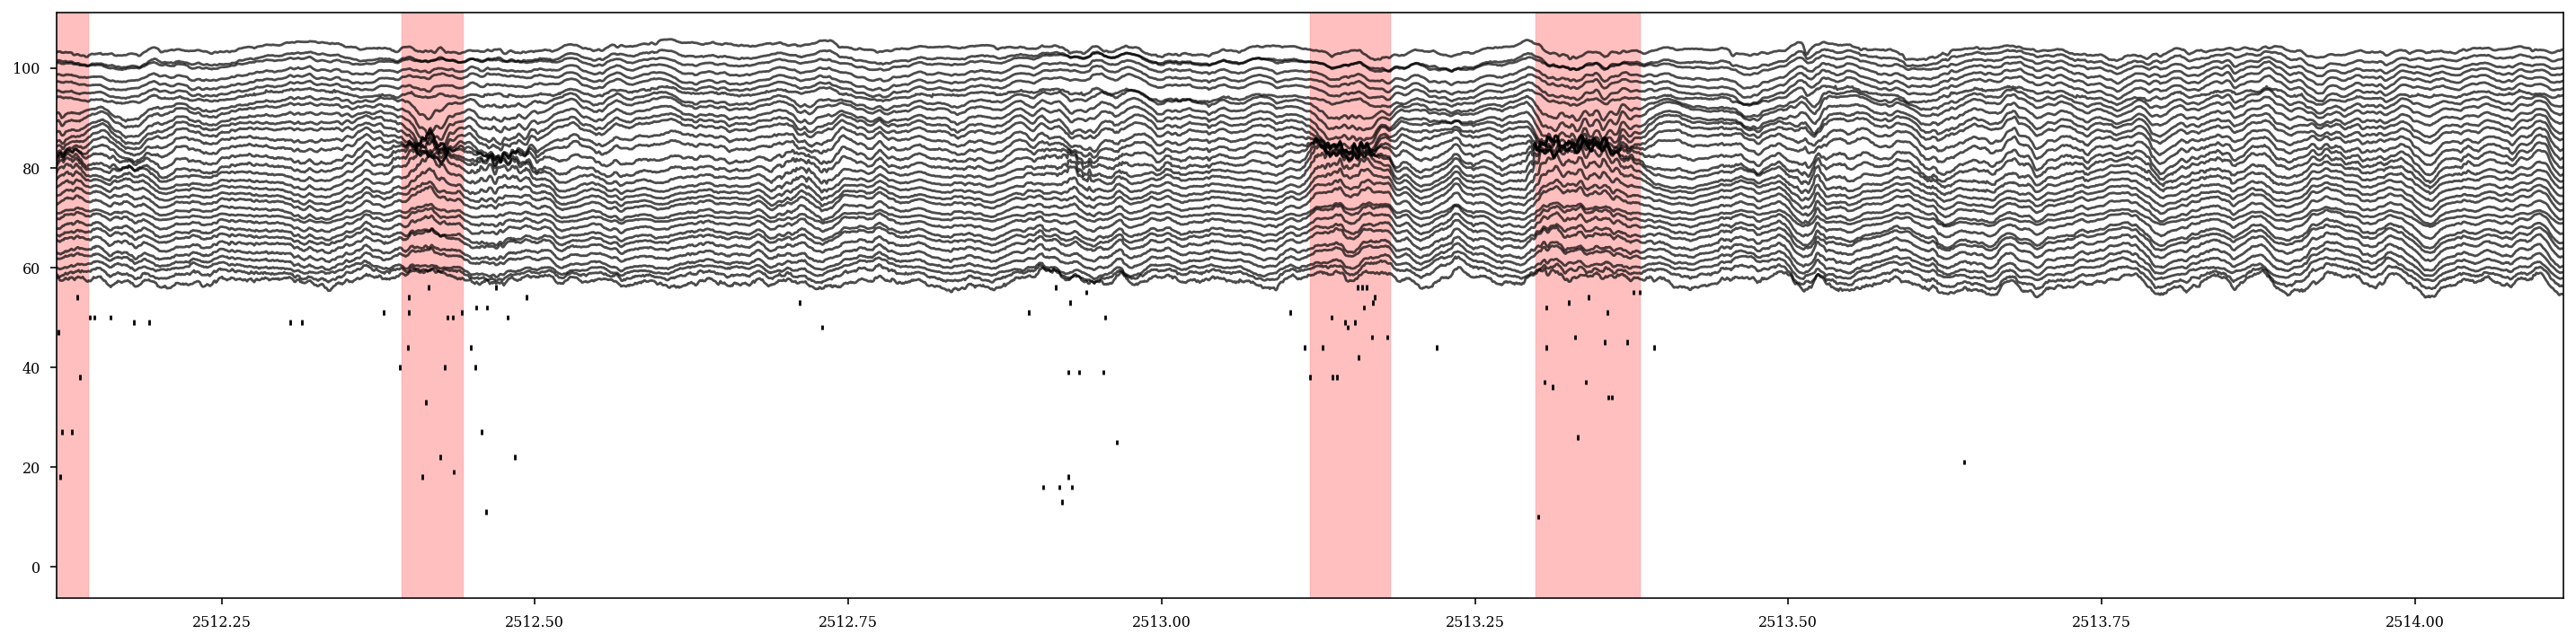

In [139]:
rip_n = 302

plotting_epoch = nel.EpochArray([np.array([ripple_epochs[rip_n].starts-1,ripple_epochs[rip_n].starts+1]).T])

idx = np.argsort(cell_metrics.ripple_particip)
plt.figure(figsize=(25,6))

offset = (np.arange(0,lfp_obj.data.shape[0])*1.5)+st_unit.n_active
plt.plot(lfp_obj[plotting_epoch]._abscissa_vals,lfp_obj[plotting_epoch].data.T+offset,color='k',alpha=.7)

plt.eventplot(st_unit[plotting_epoch].data[idx],color='k')

for rip in ripple_epochs[plotting_epoch]:
    plt.axvspan(rip.start,rip.stop,color='r',alpha=.25,zorder=-1000)
plt.xlim(plotting_epoch.start,plotting_epoch.stop)    
plt.show()